In [7]:
import sys
sys.path.append('../src')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import dask
import dask.dataframe as dd
from windpowerlib.wind_speed import logarithmic_profile
from utils import uv_to_wsd

INPUT_PATH = "../input/"

# 데이터 체크

In [2]:
# 터빈 개수가 적은 경주풍력에 대해서만 한번 진행
power = pd.read_parquet(INPUT_PATH + "dynamic_report_ewp02_2020_10min.parquet").rename({'Date/Time': 'dt', 'WTG.Name': 'turbine_id'}, axis=1)
gj_y = pd.read_parquet(INPUT_PATH + "train_y.parquet").rename({'end_datetime': 'dt'}, axis=1)
ldaps = pd.read_parquet(INPUT_PATH + "train_ldaps_gyeongju.parquet")

print("Power: ", power.shape)
print("train_y: ", gj_y.shape)
print("LDAPS: ", ldaps.shape)

Power:  (52592, 29)
train_y:  (52608, 4)
LDAPS:  (235818, 15)


In [3]:
# data slicing
power = power[:-3]

datas = [power, gj_y, ldaps]
for d in datas:
    try:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_convert("Asia/Seoul"))
    except TypeError:
        d['dt'] = (pd.to_datetime(d['dt'])
                    .dt
                    .tz_localize("Asia/Seoul"))

gj_y = (gj_y.loc[(gj_y['plant_name'] == "경주풍력")
                 & (gj_y['dt']).between('2020-01-01', '2021-01-01', inclusive='left')])

ldaps = ldaps.loc[ldaps['dt'].between('2020-01-01', '2021-01-01', inclusive='left')]

print("Power: ", power.shape, power['dt'].min(), power['dt'].max())
print("train_y: ", gj_y.shape, gj_y['dt'].min(), gj_y['dt'].max())
print("LDAPS: ", ldaps.shape, ldaps['dt'].min(), ldaps['dt'].max())

Power:  (52589, 29) 2020-01-01 00:00:00+09:00 2020-12-31 23:50:00+09:00
train_y:  (8783, 4) 2020-01-01 01:00:00+09:00 2020-12-31 23:00:00+09:00
LDAPS:  (78840, 15) 2020-01-02 00:00:00+09:00 2020-12-31 23:00:00+09:00


In [10]:
ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
    ldaps["wind_u_10m"], ldaps["wind_v_10m"]
)

ldaps["wind_speed_100m"] = logarithmic_profile(ldaps["wind_speed"], 10, 100, 0.3)

C:\Users\jhk32\AppData\Local\Temp\ipykernel_18392\4022820924.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed"], ldaps["wind_direction"] = uv_to_wsd(
C:\Users\jhk32\AppData\Local\Temp\ipykernel_18392\4022820924.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ldaps["wind_speed_100m"] = logarithmic_profile(ldaps["wind_speed"], 10, 100, 0.3)


In [21]:
# tmp = pd.merge(power, ldaps,
#                on = ['dt', 'turbine_id'])

tmp = pd.merge(ldaps, gj_y[['dt', 'energy_kwh']],
               on = ['dt'])

tmp.head()

,dt,elevation,land_cover,surf_rough,frictional_vmax_50m,frictional_vmin_50m,pressure,relative_humid,specific_humid,temp_air,storm_u_5m,storm_v_5m,wind_u_10m,wind_v_10m,turbine_id,wind_speed,wind_direction,wind_speed_100m,energy_kwh
0,2020-01-02 00:00:00+09:00,387.640625,1.0,0.286911,10.428498,10.059580,97974.59375,91.796478,0.002686,269.467560,0.021201,-0.375756,7.353266,-2.640615,WTG01,7.813025,289.753601,12.943457,17827.148438
1,2020-01-02 00:00:00+09:00,302.671875,1.0,0.316269,6.327180,5.870615,99067.59375,89.145111,0.002686,269.897491,0.021751,-0.270196,3.763056,-2.904043,WTG02,4.753320,307.658264,7.874593,17827.148438
2,2020-01-02 00:00:00+09:00,292.593750,1.0,0.307016,5.330964,4.846201,99190.34375,89.085052,0.002686,269.935577,0.022453,-0.339440,3.043085,-3.657705,WTG03,4.758064,320.240692,7.882452,17827.148438
3,2020-01-02 00:00:00+09:00,292.593750,1.0,0.307016,5.330964,4.846201,99190.34375,89.085052,0.002686,269.935577,0.022453,-0.339440,3.043085,-3.657705,WTG04,4.758064,320.240692,7.882452,17827.148438
4,2020-01-02 00:00:00+09:00,292.593750,1.0,0.307016,5.330964,4.846201,99190.34375,89.085052,0.002686,269.935577,0.022453,-0.339440,3.043085,-3.657705,WTG05,4.758064,320.240692,7.882452,17827.148438


In [22]:
tmp.columns = tmp.columns.str.replace("[", "_").str.replace("]", "")

In [23]:
# tmp = tmp.drop(['turbine_id', 'WTG.Serial'], axis=1)
tmp = tmp.drop(['turbine_id', 'wind_speed'], axis=1)

x_train = tmp.loc[tmp['dt'].between('2020-01-01', '2020-10-01', inclusive='left')].drop(['dt', 'energy_kwh'], axis=1)
x_test = tmp.loc[tmp['dt'].between('2020-10-01', '2021-01-01', inclusive='left')].drop(['dt', 'energy_kwh'], axis=1)

y_train = tmp.loc[tmp['dt'].between('2020-01-01', '2020-10-01', inclusive='left'), 'energy_kwh']
y_test = tmp.loc[tmp['dt'].between('2020-10-01', '2021-01-01', inclusive='left'), 'energy_kwh']

print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(58968, 15) (19872, 15) (58968,) (19872,)


In [39]:
import xgboost
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [25]:
xgb_params = {
    'tree_method': 'auto',
    # 'n_estimators': 1000,
    # 'max_depth': 8,
    'n_jobs': -1,
    'random_state': 1,
    'device': 'cuda'
}

xgb = XGBRegressor(**xgb_params)
xgb.fit(x_train, y_train)

c:\Users\jhk32\miniconda3\envs\windpower\lib\site-packages\xgboost\core.py:158: UserWarning: [00:25:36] WARNING: C:\b\abs_90_bwj_86a\croot\xgboost-split_1724073762025\work\src\context.cc:196: XGBoost is not compiled with CUDA support.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=-1,
             num_parallel_tree=None, random_state=1, ...)

In [26]:
y_pred = xgb.predict(x_test)

In [37]:
xgb.score(x_test, y_test)

0.5376620254226134

* v0 - 0.4622584772423298, logarithmic - 0.5376620254226134  
NMAE : 17.3 -> 16.81

In [28]:
nmae = abs(y_pred-y_test)/20700*100
nmae = round(nmae.mean(), 2)
print(nmae)

16.81


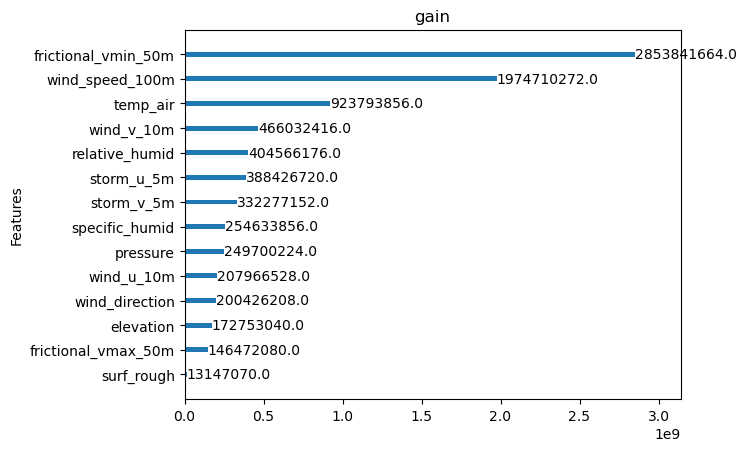

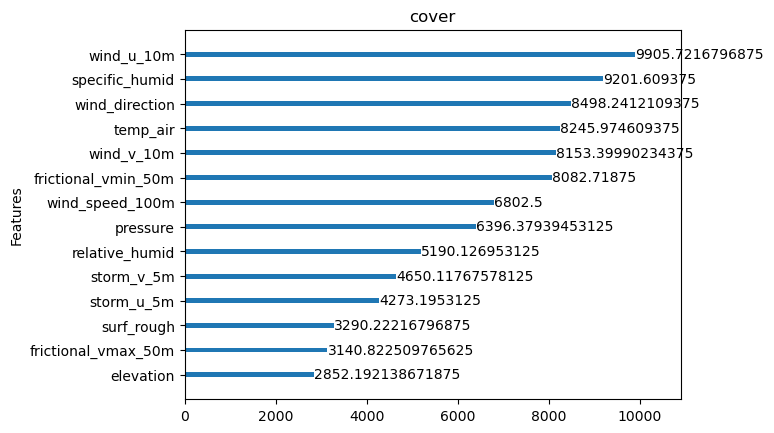

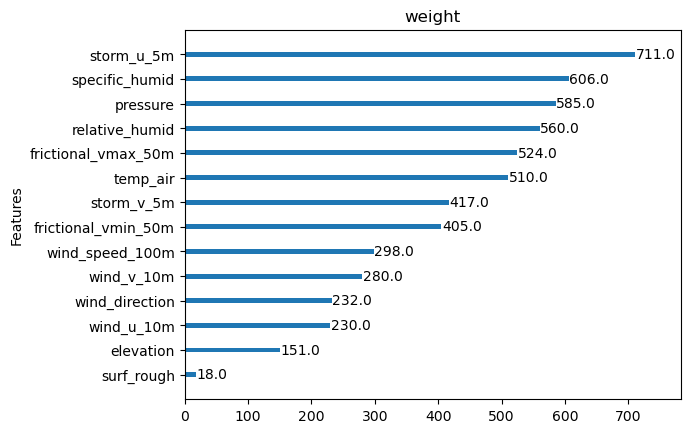

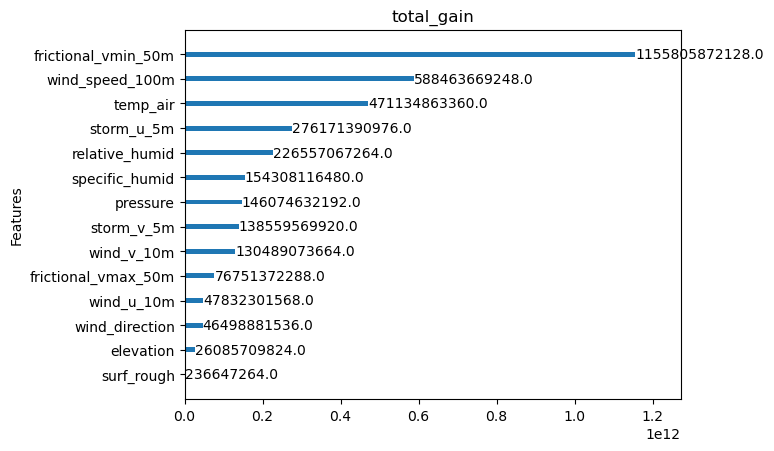

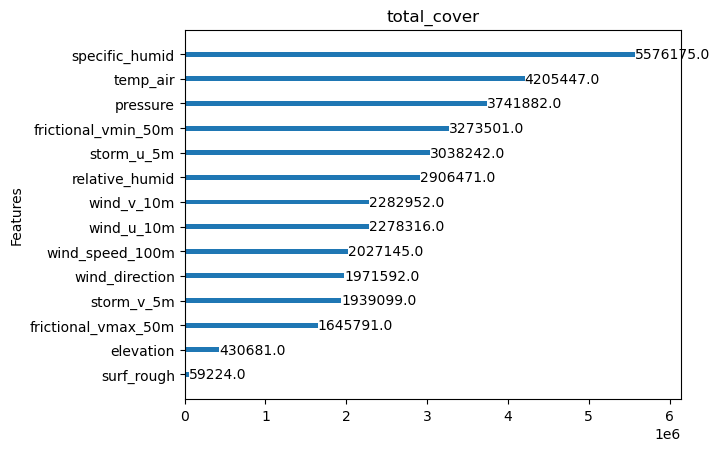

In [29]:
xgboost.plot_importance(xgb, importance_type='gain', title='gain', xlabel='', grid=False)
xgboost.plot_importance(xgb, importance_type='cover', title='cover', xlabel='', grid=False)
xgboost.plot_importance(xgb, importance_type='weight', title='weight', xlabel='', grid=False)
xgboost.plot_importance(xgb, importance_type='total_gain', title='total_gain', xlabel='', grid=False)
xgboost.plot_importance(xgb, importance_type='total_cover', title='total_cover', xlabel='', grid=False)

plt.show()

In [75]:
imp = pd.DataFrame(xgb.feature_importances_, columns=['imp'])
imp['col'] = xgb.feature_names_in_

display(imp.sort_values('imp', ascending=False))

,imp,col
14,0.580273,NacelleWindSpeed_m/s
6,0.125258,GeneratorAverageWindingTemp._℃
19,0.053741,RotorMotor2Pos._deg
30,0.029645,frictional_vmin_50m
0,0.022666,AvailabilityForcedOutageTime_Min.
12,0.015087,NacelleOutdoorTemp_℃
18,0.014457,RotorMotor1Pos._deg
11,0.011869,NacelleNacellePosition_deg
20,0.010052,RotorMotor3Pos._deg
37,0.009394,wind_u_10m
